In [1]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
import scipy.optimize as so
from scipy.interpolate import interp1d

# from jupyter_server import serverapp as app; 
# import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Helvetica"],
# })
# sns.set_theme(context='poster')
sns.set_style("white")
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.labelsize']=25
plt.rcParams['legend.fontsize']= 15
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['figure.titlesize'] = 30

In [ ]:
def m_selection_driven(UN, yc, R0, scaled_dbar):
    return UN*((1 + (R0*yc)/(-1 + R0)**2)**(1 - 1/scaled_dbar)*scaled_dbar*((-1 + R0)**2 + (R0*yc*(1 + scaled_dbar))/scaled_dbar))/(2.*R0**2*(1 + scaled_dbar))

def m_exponential(UN, yc, R0, scaled_dbar):
    return UN*yc/(R0*((1 - 2*R0 + R0**2 + R0*yc)/(-1 + R0)**2)**(1/scaled_dbar))

def m_total(UN, yc, R0, scaled_dbar):
    return m_selection_driven(UN, yc, R0, scaled_dbar) + m_exponential(UN, yc, R0, scaled_dbar)

def E_selection_driven(yc,R0, scaled_dbar):
    return scaled_dbar*\
        np.power(((1 + (R0*yc)/(-1 + R0)**2)**(1 - 1/scaled_dbar)*\
        scaled_dbar*((-1 + R0)**2 + (R0*yc*(1 + scaled_dbar))/scaled_dbar))/(2.*R0**2*(1 + scaled_dbar)),-1)

def E_exponential(yc, R0, scaled_dbar):
    return scaled_dbar*np.power(yc/(R0*((1 - 2*R0 + R0**2 + R0*yc)/(-1 + R0)**2)**(1/scaled_dbar)),-1)

def E_total(yc, R0, scaled_dbar):
    first_term = ((1 + (R0*yc)/(-1 + R0)**2)**(1 - 1/scaled_dbar)*scaled_dbar*((-1 + R0)**2 + (R0*yc*(1 + scaled_dbar))/scaled_dbar))/(2.*R0**2*(1 + scaled_dbar))
    second_term = yc/(R0*((1 - 2*R0 + R0**2 + R0*yc)/(-1 + R0)**2)**(1/scaled_dbar))
    return np.power(first_term + second_term,-1)


In [3]:


from scipy.optimize import least_squares, root_scalar
#given one of these three functions, find all the solutions
def find_yc(UN, R0, scaled_dbar, m_func, tol=1e-1):
    starting_points = [1e-3,1]  # or whatever range is sane
    solutions = []

    for yc0 in starting_points:
        try:
            sol = so.fsolve(lambda yc: m_func(UN, yc, R0, scaled_dbar) - 1, yc0)
            yc_sol = sol[0] 
            # print('solution', yc_sol)

            residual = np.abs(m_func(UN, yc_sol, R0, scaled_dbar) - 1)
            # print('residual', residual)
            
            if residual < tol:
                if not any(np.isclose(yc_sol, s, atol=tol) for s in solutions):
                    solutions.append(yc_sol)
        except Exception as e:
            print(e)
            pass

    return ([np.array([UN, yc]) for yc in solutions])

def find_yc_least_squares(UN, R0, scaled_dbar, m_func, tol=1e-3):
    starting_points = np.geomspace(1e-4, 10, 50)  # wide + positive
    solutions = []

    for yc0 in starting_points:
        res = least_squares(
            lambda yc: m_func(UN, yc[0], R0, scaled_dbar) - 1,
            x0=[yc0],
            bounds=(0, 10),
            xtol=1e-3,
            ftol=1e-3,
        )

        if res.success:
            yc_sol = res.x[0]
            residual = abs(m_func(UN, yc_sol, R0, scaled_dbar) - 1)
            if residual < tol:
                if not any(np.isclose(yc_sol, s, atol=tol) for s in solutions):
                    solutions.append(yc_sol)

    return [np.array([UN, yc]) for yc in solutions]

def find_yc_root_scalar(UN, R0, scaled_dbar, m_func, tol=1e-6):
    bracket_points = np.geomspace(1e-4, 10, 200)
    solutions = []

    def wrapped(yc):
        return m_func(UN, yc, R0, scaled_dbar) - 1

    for a, b in zip(bracket_points[:-1], bracket_points[1:]):
        try:
            if np.sign(wrapped(a)) == np.sign(wrapped(b)):
                continue  # no root in this interval
            sol = root_scalar(wrapped, bracket=[a, b], method='brentq', xtol=tol)
            if sol.converged:
                yc_sol = sol.root
                if not any(np.isclose(yc_sol, s, atol=tol) for s in solutions):
                    solutions.append(yc_sol)
        except:
            pass  # meh

    return [np.array([UN, yc]) for yc in solutions]
# ax.set_xlim([ycs[0],ycs[-1]])
# ax.set_ylim(4,1e3)

In [4]:
def plot_m_functions(UN=10, scaled_dbar=0.2, R0=2.5, ycs=None,verbose=False):
    """
    Plot the m_selection_driven, m_exponential, and m_total functions and find solutions
    where m_func(UN, yc, R0, scaled_dbar) = 1.
    
    Parameters:
    -----------
    UN : float, optional
        Parameter for the m functions. Default is 10.
    scaled_dbar : float, optional
        Parameter for the m functions. Default is 0.2.
    R0 : float, optional
        Parameter for the m functions. Default is 2.5.
    ycs : numpy.ndarray, optional
        Array of yc values. If None, will use np.logspace(-4,2,1000)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    ax : matplotlib.axes.Axes
        The axes object
    solutions : dict
        Dictionary containing the solutions for each m function
    """
    
    def verbose_print(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)

    if ycs is None:
        ycs = np.logspace(-4,2,1000)
    
    ms_selection_driven = m_selection_driven(UN, ycs, R0, scaled_dbar)
    ms_exponential = m_exponential(UN, ycs, R0, scaled_dbar)
    ms_total = m_total(UN, ycs, R0, scaled_dbar)
    
    fig, ax = plt.subplots()
    
    # Plot selection driven
    l_selection_driven, = ax.plot(ycs, ms_selection_driven, label='selection driven')
    yc_selection_driven = find_yc(UN, R0, scaled_dbar, m_selection_driven)
    verbose_print('selection driven', yc_selection_driven)
    if yc_selection_driven.size > 0:
        for yc in yc_selection_driven[:,1]:
            ax.scatter(yc, 1, color=l_selection_driven.get_color(), s=200, marker='x')
    verbose_print()
    
    # Plot exponential
    l_exponential, = ax.plot(ycs, ms_exponential, label='exponential')
    yc_exponential = find_yc(UN, R0, scaled_dbar, m_exponential)
    verbose_print('exponential', yc_exponential)
    if yc_exponential.size > 0:
        for yc in yc_exponential[:,1]:
            ax.scatter(yc, 1, color=l_exponential.get_color(), s=200, marker='x')
    verbose_print()
    
    # Plot total
    l_total, = ax.plot(ycs, ms_total, label='total')
    yc_total = find_yc(UN, R0, scaled_dbar, m_total)
    verbose_print('total', yc_total)
    if yc_total.size > 0:
        for yc in yc_total[:,1]:
            ax.scatter(yc, 1, color=l_total.get_color(), s=200, marker='x')
    
    ax.axhline(1, color='black', linestyle='--')
    
    ax.set_xscale('log')
    ax.set_xlabel('yc')
    ax.set_ylabel('m')
    ax.legend()
    
    solutions = {
        'selection_driven': yc_selection_driven,
        'exponential': yc_exponential,
        'total': yc_total
    }
    
    return fig, ax, solutions

In [5]:
#turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# subfunction: get solutions for a given mutant model
def get_model_solutions(UNs, R0, scaled_dbar, m_func):
    UNs_list, ycs_list = [], []
    for UN in tqdm(UNs, desc='finding roots'):
        sols = find_yc_root_scalar(UN, R0, scaled_dbar, m_func)
        UNs_list += [sol[0] for sol in sols]
        ycs_list += [sol[1] for sol in sols]
    return np.array(UNs_list), np.array(ycs_list)

# subfunction: sort solutions by yc (if available)
def sort_solutions(UNs, ycs):
    if UNs.size:
        order = np.argsort(ycs)
        return UNs[order], ycs[order]
    return UNs, ycs

# subfunction: calculate E values
def calc_E(UNs, scaled_dbar):
    return UNs * scaled_dbar

# subfunction: create the plot
def create_plot(plot_type, results, R0, scaled_dbar, figsize):
    vline_func_max = lambda e_arr: np.ones_like(e_arr) * np.max(e_arr)
    vline_func_min = lambda e_arr: np.ones_like(e_arr) * np.min(e_arr)
    fig, ax = plt.subplots(figsize=figsize)
    if plot_type == 'E_vs_yc':
        ax.plot(results['exponential']['ycs'], results['exponential']['Es'], label='early mutants',color= 'tomato',)
        ax.fill_between(results['exponential']['ycs'], results['exponential']['Es'], vline_func_max(results['exponential']['Es']), alpha=0.5, color='tomato')

        ax.plot(results['selection_driven']['ycs'], results['selection_driven']['Es'], label='late mutants', color='#F9C133')
        ax.fill_between(results['selection_driven']['ycs'], results['selection_driven']['Es'], vline_func_max(results['selection_driven']['Es']), alpha=0.5, 
        color='#F9C133')
        ax.plot(results['total']['ycs'], results['total']['Es'], label='all mutants',color='darkgreen')
        ylim = ax.get_ylim()
        ax.fill_between(results['total']['ycs'], ylim[0]*np.ones_like(results['total']['Es']) ,results['total']['Es'], alpha=0.5, color='grey')
        # ax.fill_between(results['total']['ycs'], results['total']['Es'], vline_func_max(results['total']['Es']), alpha=0.5, color='darkgreen')  

        ax.set_xlabel('$y_c$')
        ax.set_ylabel('$E$')
    elif plot_type == 'UN_vs_yc':
        ax.scatter(results['selection_driven']['ycs'], results['selection_driven']['UNs'], label='late mutants', s=10)
        ax.scatter(results['exponential']['ycs'], results['exponential']['UNs'], label='early mutants', s=10)
        ax.scatter(results['total']['ycs'], results['total']['UNs'], label='all mutants', s=10)
        ax.set_xlabel('$y_c$')
        ax.set_ylabel('$U_N$')
    ax.legend(fontsize=25, loc='upper left')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(fr'$R_0 = {R0} \qquad \bar{{d}}/\xi = {scaled_dbar}$', y=1.02)
    return fig, ax

# main phase diagram function refactored into subfunctions
def phase_diagram(R0=2.5, scaled_dbar=0.2, UNs=None, num_points=5000, 
                  plot_type='E_vs_yc', plot=True, figsize=(10,10)):
    # set up UNs array if not provided
    if UNs is None:
        UNs = np.logspace(0, 3, num_points)
    
    # get solutions for each model
    UNs_sel, ycs_sel = get_model_solutions(UNs, R0, scaled_dbar, m_selection_driven)
    UNs_exp, ycs_exp = get_model_solutions(UNs, R0, scaled_dbar, m_exponential)
    UNs_tot, ycs_tot = get_model_solutions(UNs, R0, scaled_dbar, m_total)
    
    # sort solutions by yc
    UNs_sel, ycs_sel = sort_solutions(UNs_sel, ycs_sel)
    UNs_exp, ycs_exp = sort_solutions(UNs_exp, ycs_exp)
    UNs_tot, ycs_tot = sort_solutions(UNs_tot, ycs_tot)
    
    # calc E values for each model
    Es_sel = calc_E(UNs_sel, scaled_dbar)
    Es_exp = calc_E(UNs_exp, scaled_dbar)
    Es_tot = calc_E(UNs_tot, scaled_dbar)
    
    # package results in a dict
    results = {
        'selection_driven': {'UNs': UNs_sel, 'ycs': ycs_sel, 'Es': Es_sel},
        'exponential': {'UNs': UNs_exp, 'ycs': ycs_exp, 'Es': Es_exp},
        'total': {'UNs': UNs_tot, 'ycs': ycs_tot, 'Es': Es_tot}
    }
    
    # plot if requested
    if plot:
        fig, ax = create_plot(plot_type, results, R0, scaled_dbar, figsize)
        return results, fig, ax
    else:
        return results, None, None

In [7]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [8]:
# # for scaled_dbar in [.1,.2,.5]:
# scaled_dbar = .2
# for R0 in [1.5,2,2.5,3]:
#     phase_diagram(R0, scaled_dbar=scaled_dbar, UNs=None, num_points=100000,);



(0.0001, 3.1622776601683795)

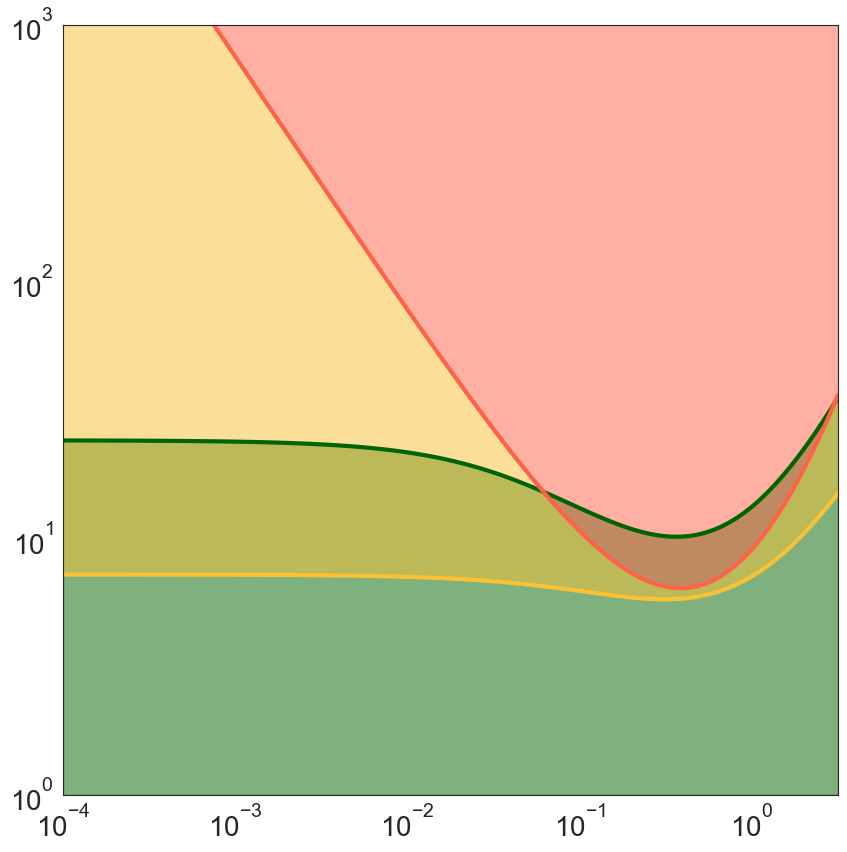

In [14]:
scaled_dbar = 0.3
R0 = 2.5

ycs = np.logspace(-4,.5,100)
Es_total = E_total(ycs, R0, scaled_dbar)
Es_selection_driven = E_selection_driven(ycs, R0, scaled_dbar)
Es_exponential = E_exponential(ycs, R0, scaled_dbar)

fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(ycs, Es_total, label='Total',color='darkgreen')
ax.fill_between(ycs,1, Es_total, alpha=0.5, color='darkgreen')
ax.plot(ycs, Es_selection_driven, label='late mutants', color='#F9C133')
ax.fill_between(ycs,Es_selection_driven, Es_exponential, alpha=0.5, color='#F9C133')
ax.plot(ycs, Es_exponential, label='early mutants',color= 'tomato',)
ax.fill_between(ycs,Es_exponential,1e3, alpha=0.5, color='tomato')

# ax.fill_between(ycs,Es_total,Es_selection_driven, alpha=0.9, color='darkred')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1,1e3)
ax.set_xlim([ycs[0],ycs[-1]])
# plt.savefig(output_folder+f'/fig2.1_invtest_R0{R0:.2f}_delta{scaled_dbar:.2f}.svg', bbox_inches='tight')